<a href="https://colab.research.google.com/github/22083111/LLM/blob/main/LLM%22s_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    confusion_matrix
)
import seaborn as sns
import torch


In [ ]:
def mount_google_drive(mount_point: str = "/content/drive"):
    """
    Mounts Google Drive in a Google Colab environment to enable file access.

    Args:
        mount_point (str, optional): The directory path where Google Drive will be mounted.
                                     Defaults to '/content/drive'.

    Returns:
        None

    Example:
        mount_google_drive()
    """
    from google.colab import drive
    drive.mount(mount_point)

# Call the function
mount_google_drive()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

def load_dataset(csv_path: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame and displays the first few rows.

    Args:
        csv_path (str): The file path to the CSV dataset.

    Returns:
        pd.DataFrame: The loaded DataFrame containing the dataset.

    Example:
        df = load_dataset("/content/drive/MyDrive/IMDB Dataset.csv")
    """

    df = pd.read_csv(csv_path)
    print("First 5 rows of the dataset:")
    display(df.head())
    return df

# Call the function
csv_path = "/content/drive/MyDrive/IMDB Dataset.csv"
df = load_dataset(csv_path)


First 5 rows of the dataset:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def map_sentiment_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps sentiment labels ('positive' and 'negative') in the 'sentiment' column
    of the DataFrame to numeric labels (1 and 0), and creates a new column 'label'.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'sentiment' column.

    Returns:
        pd.DataFrame: The DataFrame with an additional 'label' column containing numeric labels.

    Example:
        df = map_sentiment_labels(df)
    """
    label_map = {"positive": 1, "negative": 0}
    df["label"] = df["sentiment"].map(label_map)
    print("First 5 rows with numeric labels:")
    print(df.head())
    return df

# Call the function
df = map_sentiment_labels(df)


First 5 rows with numeric labels:
                                              review sentiment  label
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


In [ ]:
def convert_df_to_hf_dataset(df: "pd.DataFrame") -> "Dataset":
    """
    Converts a pandas DataFrame into a Hugging Face Dataset.

    Args:
        df (pd.DataFrame): The pandas DataFrame to convert.

    Returns:
        Dataset: A Hugging Face Dataset object created from the DataFrame.

    Example:
        dataset = convert_df_to_hf_dataset(df)
    """

    dataset = Dataset.from_pandas(df)
    return dataset

# Call the function
dataset = convert_df_to_hf_dataset(df)


Label counts:
label
1    25000
0    25000
Name: count, dtype: int64


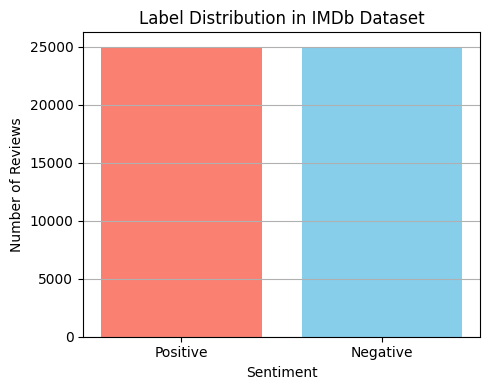

In [ ]:
def plot_label_distribution(df: "pd.DataFrame") -> None:
    """
    Counts the distribution of sentiment labels in the DataFrame and plots a bar chart.

    The function:
        - Counts occurrences of each numeric label.
        - Maps numeric labels to text labels ('Negative' and 'Positive').
        - Prints label counts for verification.
        - Plots a bar chart showing the distribution.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'label' column.

    Returns:
        None

    Example:
        plot_label_distribution(df)
    """
    # Count labels
    label_counts = df["label"].value_counts(dropna=False)

    if label_counts.empty:
        print("No labels found in DataFrame. Please check the 'label' column.")
        return

    # Print counts
    print("Label counts:")
    print(label_counts)

    # Map numeric labels to text
    label_names = {0: "Negative", 1: "Positive"}
    labels = [label_names.get(i, str(i)) for i in label_counts.index]

    # Plot
    plt.figure(figsize=(5, 4))
    plt.bar(labels, label_counts.values, color=["salmon", "skyblue"])
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Reviews")
    plt.title("Label Distribution in IMDb Dataset")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Call the function
plot_label_distribution(df)


In [ ]:
def split_train_test(dataset: "Dataset", test_size: float = 0.2, seed: int = 42) -> "DatasetDict":
    """
    Splits a Hugging Face Dataset into training and testing subsets.

    Args:
        dataset (Dataset): The Hugging Face Dataset to split.
        test_size (float, optional): Proportion of the dataset to include in the test split.
                                     Defaults to 0.2.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        DatasetDict: A dictionary containing 'train' and 'test' Dataset objects.

    Example:
        split_dataset = split_train_test(dataset)
    """
    split_dataset = dataset.train_test_split(test_size=test_size, seed=seed)
    print("Dataset split completed. Split keys:", split_dataset.keys())
    return split_dataset

# Call the function
split_dataset = split_train_test(dataset)


Dataset split completed. Split keys: dict_keys(['train', 'test'])


In [ ]:
def load_bert_tokenizer(model_name: str = "bert-base-uncased") -> "AutoTokenizer":
    """
    Loads a BERT tokenizer from the Hugging Face Transformers library.

    Args:
        model_name (str, optional): The name of the pre-trained BERT model tokenizer to load.
                                    Defaults to 'bert-base-uncased'.

    Returns:
        AutoTokenizer: The loaded tokenizer object.

    Example:
        tokenizer = load_bert_tokenizer()
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Tokenizer '{model_name}' loaded successfully.")
    return tokenizer

# Call the function
tokenizer = load_bert_tokenizer()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer 'bert-base-uncased' loaded successfully.


In [ ]:
def tokenize_and_map_dataset(dataset: "DatasetDict", tokenizer: "AutoTokenizer", max_length: int = 128) -> "DatasetDict":
    """
    Tokenizes the text reviews in a Hugging Face DatasetDict using the provided tokenizer.

    Args:
        dataset (DatasetDict): The dataset dictionary containing 'train' and 'test' splits.
        tokenizer (AutoTokenizer): The tokenizer to use for encoding the text.
        max_length (int, optional): The maximum sequence length for padding/truncation.
                                    Defaults to 128.

    Returns:
        DatasetDict: The tokenized dataset.

    Example:
        tokenized_dataset = tokenize_and_map_dataset(split_dataset, tokenizer)
    """
    def tokenize_function(examples):
        return tokenizer(
            examples["review"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    print("Tokenization completed.")
    return tokenized_dataset

# Call the function
tokenized_dataset = tokenize_and_map_dataset(split_dataset, tokenizer)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenization completed.


In [ ]:
def show_first_tokenized_example(tokenized_dataset: "DatasetDict") -> None:
    """
    Displays the first tokenized example from the training split of a tokenized DatasetDict.

    Args:
        tokenized_dataset (DatasetDict): The tokenized dataset containing 'train' and 'test' splits.

    Returns:
        None

    Example:
        show_first_tokenized_example(tokenized_dataset)
    """
    first_example = tokenized_dataset["train"][0]
    print("First tokenized training example:")
    print(first_example)

# Call the function
show_first_tokenized_example(tokenized_dataset)


First tokenized training example:
{'review': "The film disappointed me for many reasons: first of all the depiction of a future which seemed at first realistic to me was well-built but did only feature a marginal role. Then, the story itself was a weak copy of Lost in Translation. The Middle-Eastern setting, man with family meets new girl overseas, karaoke bar, the camera movements and the imagery - all that was a very bad imitation of the excellent Lost in Translation which had also credibility. This movie tries to be something brilliant and cultural: it is not. I wonder why Tim Robbins even considered doing this film!? The female main actress is awful - did she play the precog in Minority Report? And why do you have to show the vagina in a movie like this? Lost in Translation didn't have to show excessive love scenes. R-Rated just for this? This movie isn't even worth watching it from a videostore!", 'sentiment': 'negative', 'label': 0, 'input_ids': [101, 1996, 2143, 9364, 2033, 2005

Computed review lengths. Example:
                                              review  review_length
0  One of the other reviewers has mentioned that ...            307
1  A wonderful little production. <br /><br />The...            162
2  I thought this was a wonderful way to spend ti...            166
3  Basically there's a family where a little boy ...            138
4  Petter Mattei's "Love in the Time of Money" is...            230


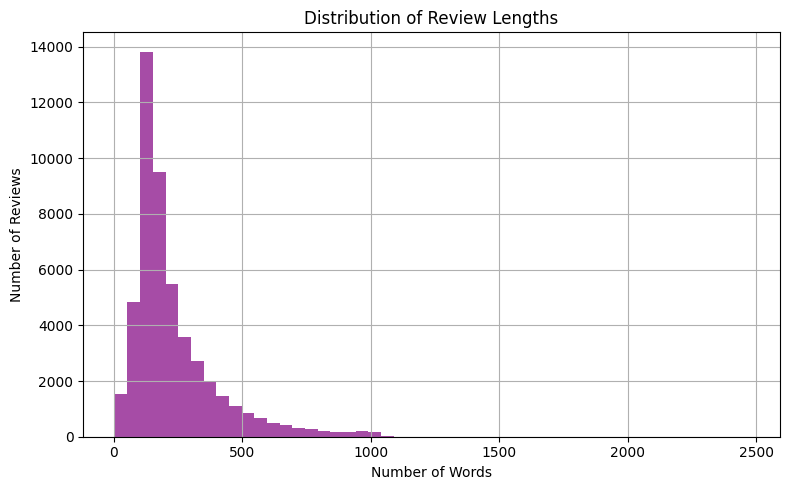

In [ ]:
def compute_and_plot_review_lengths(df: "pd.DataFrame") -> "pd.DataFrame":
    """
    Computes the number of words in each review, adds a 'review_length' column,
    and plots a histogram showing the distribution of review lengths.

    Args:
        df (pd.DataFrame): The DataFrame containing a 'review' column.

    Returns:
        pd.DataFrame: The DataFrame with the new 'review_length' column.

    Example:
        df = compute_and_plot_review_lengths(df)
    """
    # Compute lengths
    df["review_length"] = df["review"].apply(lambda x: len(x.split()))
    print("Computed review lengths. Example:")
    print(df[["review", "review_length"]].head())

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(df["review_length"], bins=50, color="purple", alpha=0.7)
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Reviews")
    plt.title("Distribution of Review Lengths")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return df

# Call the function
df = compute_and_plot_review_lengths(df)


model training


In [ ]:
def load_bert_sequence_classification_model(model_name: str = "bert-base-uncased", num_labels: int = 2) -> "AutoModelForSequenceClassification":
    """
    Loads a pre-trained BERT model for sequence classification.

    Args:
        model_name (str, optional): The name of the pre-trained BERT model to load.
                                    Defaults to 'bert-base-uncased'.
        num_labels (int, optional): The number of labels for classification.
                                    Defaults to 2 (binary classification).

    Returns:
        AutoModelForSequenceClassification: The loaded BERT model.

    Example:
        model = load_bert_sequence_classification_model()
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    print(f"Model '{model_name}' loaded with {num_labels} labels.")
    return model

# Call the function
model = load_bert_sequence_classification_model()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 'bert-base-uncased' loaded with 2 labels.


In [ ]:
def create_training_arguments(
    output_dir: str = "./bert-imdb-results",
    eval_strategy: str = "epoch",
    learning_rate: float = 2e-5,
    train_batch_size: int = 8,
    eval_batch_size: int = 8,
    num_epochs: int = 3,
    weight_decay: float = 0.01,
    save_total_limit: int = 1,
    logging_dir: str = "./logs",
    logging_steps: int = 50
) -> "TrainingArguments":
    """
    Creates TrainingArguments for Hugging Face Trainer.

    Args:
        output_dir (str, optional): Directory to save model checkpoints and outputs.
        eval_strategy (str, optional): Evaluation strategy ('steps' or 'epoch').
        learning_rate (float, optional): Learning rate for training.
        train_batch_size (int, optional): Batch size per device during training.
        eval_batch_size (int, optional): Batch size per device during evaluation.
        num_epochs (int, optional): Total number of training epochs.
        weight_decay (float, optional): Weight decay for optimizer.
        save_total_limit (int, optional): Maximum number of checkpoints to keep.
        logging_dir (str, optional): Directory to save logs.
        logging_steps (int, optional): Frequency of logging.

    Returns:
        TrainingArguments: The configured training arguments object.

    Example:
        training_args = create_training_arguments()
    """
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy=eval_strategy,
        learning_rate=learning_rate,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        save_total_limit=save_total_limit,
        logging_dir=logging_dir,
        logging_steps=logging_steps,
        report_to="none"
    )
    print("TrainingArguments created successfully.")
    return training_args

# Call the function
training_args = create_training_arguments()


TrainingArguments created successfully.


In [ ]:
def create_trainer(
    model: "AutoModelForSequenceClassification",
    training_args: "TrainingArguments",
    tokenized_dataset: "DatasetDict",
    tokenizer: "AutoTokenizer"
) -> "Trainer":
    """
    Creates a Hugging Face Trainer for model training and evaluation.

    Args:
        model (AutoModelForSequenceClassification): The model to train.
        training_args (TrainingArguments): The training configuration.
        tokenized_dataset (DatasetDict): The tokenized dataset with 'train' and 'test' splits.
        tokenizer (AutoTokenizer): The tokenizer used for preprocessing.

    Returns:
        Trainer: The configured Trainer object.

    Example:
        trainer = create_trainer(model, training_args, tokenized_dataset, tokenizer)
    """
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer
    )
    print("Trainer created successfully.")
    return trainer

# Call the function
trainer = create_trainer(model, training_args, tokenized_dataset, tokenizer)


/tmp/ipython-input-26-1853746317.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer created successfully.


In [ ]:
def train_model(trainer: "Trainer") -> "Trainer":
    """
    Fine-tunes the model using the provided Trainer instance.

    Args:
        trainer (Trainer): The Trainer object configured for training.

    Returns:
        Trainer: The same Trainer object after training is completed.

    Example:
        trainer = train_model(trainer)
    """
    print("Starting training...")
    trainer.train()
    print("Training completed.")
    return trainer

# Call the function
trainer = train_model(trainer)


Starting training...


Epoch,Training Loss,Validation Loss
1,0.355500,0.293498
2,0.243800,0.385123


Epoch,Training Loss,Validation Loss
1,0.355500,0.293498
2,0.243800,0.385123
3,0.174400,0.522749


Training completed.


In [ ]:
def evaluate_model(trainer: "Trainer") -> dict:
    """
    Evaluates the trained model on the evaluation dataset.

    Args:
        trainer (Trainer): The Trainer object with the trained model.

    Returns:
        dict: A dictionary containing evaluation metrics.

    Example:
        metrics = evaluate_model(trainer)
    """
    print("Evaluating the model...")
    metrics = trainer.evaluate()
    print("Evaluation metrics:")
    print(metrics)
    return metrics

# Call the function
metrics = evaluate_model(trainer)


Evaluating the model...


Evaluation metrics:
{'eval_loss': 0.5227486491203308, 'eval_runtime': 75.8296, 'eval_samples_per_second': 131.875, 'eval_steps_per_second': 16.484, 'epoch': 3.0}


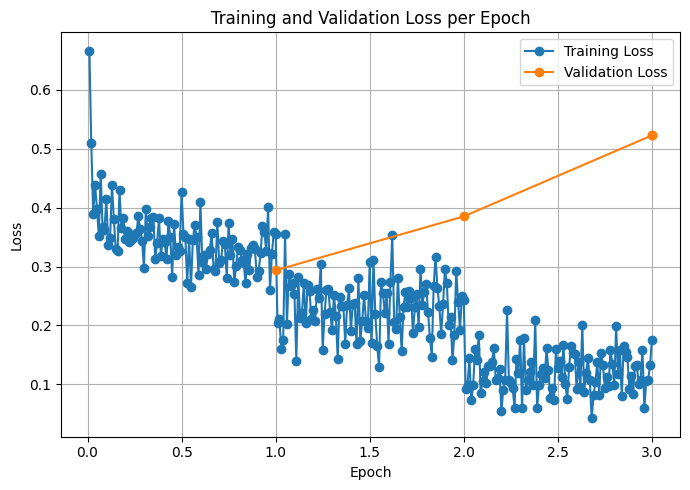

Loss plot generated successfully.


In [ ]:
def plot_training_validation_loss(trainer: "Trainer") -> None:
    """
    Converts the Trainer log history to a DataFrame, computes average training loss
    per epoch, extracts validation loss, and plots both over epochs.

    Args:
        trainer (Trainer): The Trainer object after training.

    Returns:
        None

    Example:
        plot_training_validation_loss(trainer)
    """
    # Convert log history to DataFrame
    logs = pd.DataFrame(trainer.state.log_history)

    if logs.empty:
        print("No log history found in the Trainer state.")
        return

    # Compute average training loss per epoch
    train_loss_per_epoch = logs.groupby("epoch")["loss"].mean()

    # Extract validation loss
    eval_logs = logs.dropna(subset=["eval_loss"]).set_index("epoch")

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(train_loss_per_epoch.index, train_loss_per_epoch.values, marker="o", label="Training Loss")
    plt.plot(eval_logs.index, eval_logs["eval_loss"].values, marker="o", label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    print("Loss plot generated successfully.")

# Call the function
plot_training_validation_loss(trainer)


Generating predictions on the test set...


Accuracy: 0.8969
Precision: 0.8882
Recall: 0.9050
F1 Score: 0.8965
RMSE: 0.3211


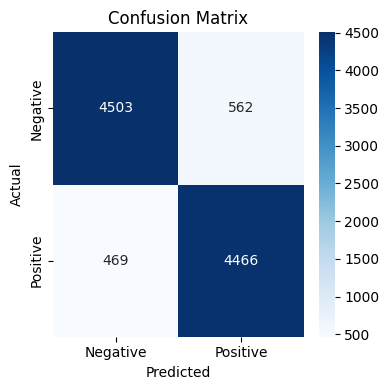

In [ ]:
def evaluate_predictions(
    trainer: "Trainer",
    tokenized_dataset: "DatasetDict"
) -> dict:
    """
    Generates predictions on the test set, computes performance metrics,
    and plots a confusion matrix.

    Args:
        trainer (Trainer): The trained Hugging Face Trainer.
        tokenized_dataset (DatasetDict): The tokenized dataset with 'test' split.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, F1, MSE, and RMSE.

    Example:
        metrics = evaluate_predictions(trainer, tokenized_dataset)
    """
    print("Generating predictions on the test set...")
    predictions = trainer.predict(tokenized_dataset["test"])
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Return metrics as dict
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "mse": mse,
        "rmse": rmse
    }
    return metrics

# Call the function
metrics = evaluate_predictions(trainer, tokenized_dataset)


In [ ]:
def predict_sentiment(
    model: "AutoModelForSequenceClassification",
    tokenizer: "AutoTokenizer",
    text: str,
    max_length: int = 128
) -> str:
    """
    Predicts the sentiment of a single text input using the trained model.

    Args:
        model (AutoModelForSequenceClassification): The trained BERT model.
        tokenizer (AutoTokenizer): The tokenizer used for preprocessing.
        text (str): The input text to classify.
        max_length (int, optional): Maximum sequence length for tokenization. Defaults to 128.

    Returns:
        str: The predicted sentiment label ('positive' or 'negative').

    Example:
        label = predict_sentiment(model, tokenizer, "This movie was great!")
    """
    # Ensure model is on correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits).item()

    label_map = {0: "negative", 1: "positive"}
    predicted_label = label_map[predicted_class_id]

    # Print result
    print(f"Review: '{text}'")
    print(f"Predicted sentiment: {predicted_label}")

    return predicted_label

# Call the function
_ = predict_sentiment(
    model,
    tokenizer,
    "This movie was absolutely fantastic!"
)


Review: 'This movie was absolutely fantastic!'
Predicted sentiment: positive


In [ ]:
def batch_predict_sentiments(
    model: "AutoModelForSequenceClassification",
    tokenizer: "AutoTokenizer",
    texts: list,
    max_length: int = 128
) -> list:
    """
    Predicts the sentiment for a list of texts using the trained model.

    Args:
        model (AutoModelForSequenceClassification): The trained BERT model.
        tokenizer (AutoTokenizer): The tokenizer used for preprocessing.
        texts (list): A list of text strings to classify.
        max_length (int, optional): Maximum sequence length for tokenization. Defaults to 128.

    Returns:
        list: A list of predicted sentiment labels ('positive' or 'negative') for each text.

    Example:
        predictions = batch_predict_sentiments(model, tokenizer, texts)
    """
    # Ensure model is on the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    label_map = {0: "negative", 1: "positive"}
    predictions = []

    for text in texts:
        # Tokenize
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_id = torch.argmax(logits).item()

        predicted_label = label_map[predicted_class_id]
        predictions.append(predicted_label)

        # Print result
        print(f"Review: '{text}'")
        print(f"Predicted sentiment: {predicted_label}")
        print("---")

    return predictions

# Call the function
texts = [
    "I hated every minute of this movie.",
    "An unforgettable performance and a great story.",
    "This was just okay, not terrible but not good either."
]

_ = batch_predict_sentiments(model, tokenizer, texts)


Review: 'I hated every minute of this movie.'
Predicted sentiment: negative
---
Review: 'An unforgettable performance and a great story.'
Predicted sentiment: positive
---
Review: 'This was just okay, not terrible but not good either.'
Predicted sentiment: negative
---


Correct predictions: 8969
Incorrect predictions: 1031


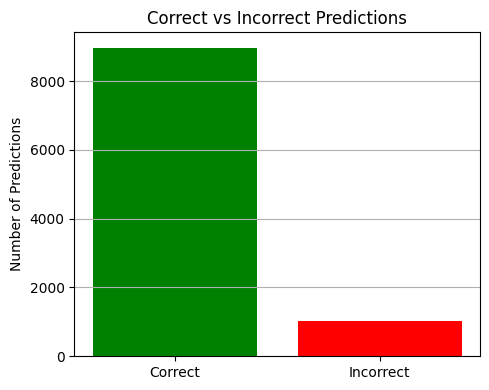

In [ ]:
def predict_and_plot_correctness(
    trainer: "Trainer",
    tokenized_dataset: "DatasetDict"
) -> None:
    """
    Predicts on the test set, computes correct vs. incorrect counts,
    and plots them in a bar chart.

    Args:
        trainer (Trainer): The trained Hugging Face Trainer.
        tokenized_dataset (DatasetDict): The dataset with 'test' split.

    Returns:
        None

    Example:
        predict_and_plot_correctness(trainer, tokenized_dataset)
    """
    # Predict
    predictions = trainer.predict(tokenized_dataset["test"])
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Compute counts
    correct = (y_pred == y_true).sum()
    incorrect = (y_pred != y_true).sum()

    # Print counts
    print(f"Correct predictions: {correct}")
    print(f"Incorrect predictions: {incorrect}")

    # Plot
    plt.figure(figsize=(5, 4))
    plt.bar(["Correct", "Incorrect"], [correct, incorrect], color=["green", "red"])
    plt.ylabel("Number of Predictions")
    plt.title("Correct vs Incorrect Predictions")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Call the function
predict_and_plot_correctness(trainer, tokenized_dataset)


In [ ]:
def save_trained_model(trainer: "Trainer", output_dir: str = "./bert-imdb-finetuned") -> None:
    """
    Saves the trained model to the specified directory.

    Args:
        trainer (Trainer): The trained Hugging Face Trainer object.
        output_dir (str, optional): Directory where the model will be saved.
                                    Defaults to './bert-imdb-finetuned'.

    Returns:
        None

    Example:
        save_trained_model(trainer)
    """
    trainer.save_model(output_dir)
    print(f"Model saved to '{output_dir}'.")

# Call the function
save_trained_model(trainer)


Model saved to './bert-imdb-finetuned'.
